# Chapter 3: Classification

Nesse capítulo discutiremos sobre tarefas de classificação. Nelas, o modelo aprende a classificar uma instância em uma ou mais classes.

## MNIST

MNIST é um dataset **MUITO** famoso no mundo do ML que basicamente reune alguns dígitos (70k) escritos a mão por estudantes e empregados. Cada uma das imagens possue um label que é a resposta.

Vamos importá-lo!

In [12]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

In [14]:
mnist = loadmat("./datasets/mnist-original.mat")

X, y = mnist["data"].T, mnist["label"][0]
print(X.shape, y.shape)

(70000, 784) (70000,)


Vamos ver o formato de um dígito!

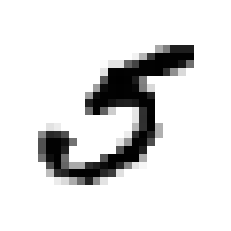

the label is: 5


In [16]:
some_index = 36000
some_digit = X[some_index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()
print('the label is:', int(y[some_index]))

Este dataset já é dividido em treino e teste. Os 60k primeiros são treino e os 10k finais são teste.

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Mas veja como está o treino:

In [20]:
y_train # treino ordenado!!!

array([0., 0., 0., ..., 9., 9., 9.])

Vamos embaralhar!

In [22]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [24]:
shuffle_index

array([25088, 50397, 37807, ..., 29722, 35596, 22423])

## Treinando um classificador binário

Vamos criar e treinar um classificador que identifica quando o dígito é ou não 5!

In [26]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [28]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
pass

Vamo prever o 5 visto lá em cima!

In [30]:
sgd_clf.predict([some_digit])

array([ True])

Ok, nosso modelo acertou uma predição! Mas qual a performance real dele?

## Medidas de performance

A performance de classificadores é muito diferente e bem mais minusciosa que a de regressores, por isso vamos ter uma longa discussão sobre o assunto.

### Cross-Validation

De novo? é, mas pior

In [32]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [34]:
print('acc mean: {:.2f}'.format(scores.mean()))
print('acc std: {:.2f}'.format(scores.std()))

acc mean: 0.96
acc std: 0.01


UAU, belo score, não?

Mas... vamos comparar com um modelo que sempre chuta 'não é 5'

In [36]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [38]:
never_5_clf = Never5Classifier()
scores = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [41]:
print('acc mean: {:.2f}'.format(scores.mean()))
print('acc std: {:.2f}'.format(scores.std()))

acc mean: 0.91
acc std: 0.00


Isso ocorre porque 90% dos dados não são 5's!

Assim, acurácia nem sempre é uma boa métrica.

### Matriz de confusão

Serve para contar quantas vezes a classe A foi predita como B e vice versa, classe a classe.

Vamos tentar prever o treino com predição cruzada.

In [43]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

sabendo os valores reais {y_train_5} e os valores preditos {y_train_pred}, podemos montar a matriz de confusão.

As linhas representam a label verdadeira

As colunas representam a previsão do modelo

In [45]:
from sklearn.metrics import confusion_matrix
m = confusion_matrix(y_train_5, y_train_pred)
m

array([[53146,  1433],
       [ 1135,  4286]])

![](./imgs/confusionmatrix.png)

In [47]:
print("{:5d} não 5's previstos corretamente".format(m[0][0]))
print("{:5d} 5's previstos corretamente".format(m[1][1]))
print("{:5d} não 5's previstos erroneamente".format(m[0][1]))
print("{:5d} 5's previstos erroneamente".format(m[1][0]))


53146 não 5's previstos corretamente
 4286 5's previstos corretamente
 1433 não 5's previstos erroneamente
 1135 5's previstos erroneamente


Essa matriz fica muito cheia de informação quando se tem mais de 2 classes. Que tal criarmos uma métrica numérica?

#### precision

$$ precision = \frac{TP}{TP + FP}$$

* TP: True positive
* FP: False positive

Note que isso significa que a precisão é, falando por extenso, quantos % dos previstos positivos são positivos

#### Recall

$$recall = \frac{TP}{TP + FN}$$

* TP: True positive
* FN: False negative

Note que isso significa que o recall é a quantidade de previsões positivas corretas sobre o total de positivos reais.

### Precision and Recall

In [49]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.7494317188319636, 0.7906290352333518)

Ainda são 2 métricas, vamos juntar em uma?

#### F1-score

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [51]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7694793536804309

O F1 é uma média harmônica e favorece valores parecidos de precisão e recall, o que nem sempre é o que a gente quer, né? As vezes é mais importante não ter falso positivo ou não ter falso negativo.

Se você quer acertar se uma transação é golpe ou não, é melhor você dizer que algumas são mesmo que não sejam, mas garantindo que a maior parte dos golpes reais sejam detectados.

Percebe que quando falamos disso a gente escolhe ganhar de um lado para perder do outro? Isso ocorre porque encontramos mais um tradeoff:

### Precision/Recall tradeoff

Como um classificador escolhe a classe? Basicamente ele vai gerar um score baseado numa *decision function*. Se esse score for maior que um *threshold*, essa instância vai ser classificada como classe B, se for menor, como classe A.

![](./imgs/precisionrecalltradeoff.png)


aumentar o threshold diminui o recall e aumenta a precisão. Há menos falso negativos

Diminuir o threshold aumenta o recall e diminui a precisão.

In [53]:
threshold = 0
y_scores = sgd_clf.decision_function([some_digit])
y_some_digit_pred = (y_scores > threshold)

y_scores,  y_some_digit_pred

(array([[ -6586.26509167, -16035.51864084,  -9722.54554815,
          -1948.26325042, -13493.93327599,   1609.35877433,
         -19762.07284916, -15479.5960437 ,  -7332.44412716,
         -24353.8235989 ]]),
 array([[False, False, False, False, False,  True, False, False, False,
         False]]))

In [55]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

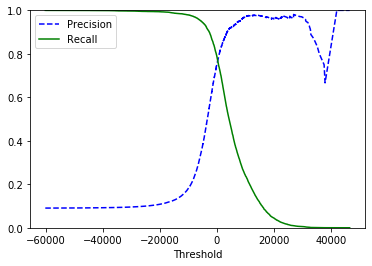

In [57]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

A curva da precisão não é suave pois ela pode diminuir ao aumentar o threshold e gerar um falso negativo. Exemplo:

temos 5 elementos classificados como positivos, 4 são true positives e 1 é false positive. Assim, a precisão é 80% (4/5) mas se você aumenta o threshold e passa a ter 4 positivos sendo 3 true e 1 false vc fica com 75% (3/4) de precisão.

### The ROC curve

The receiver operating characteristic (ROC) curve.

É uma outra ferramenta comum para classificadores binários. Bem similar a curva de precision/recall mas ao invés de plotar precisão e recall, plota *true positive rate* (recall) por *false positive rate* (FPR). FPR é a taxa de instâncias negativas classificadas como positivas. Vamos plotar isso.

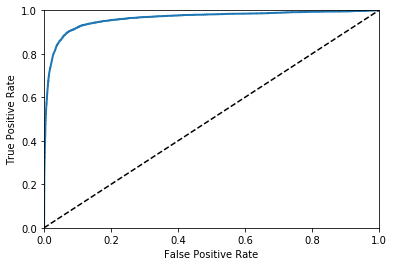

In [59]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

O resultado ideal seria FPR = 0 e TPR = 1. O que claramente não dá pra alcançar com nosso modelo :/...

pontos importantes:

* Quando mais perto do canto superior esquerdo, melhor
* Uma boa forma de medir isso é sabendo a área sob o gráfico! Um modelo merda tem um gráfico parecido com esse preto aí (área de 0.5), um modelo perfeito aconteceria se sua curva tocasse o ponto (0,1) e a área sob ela fosse 1. O que é praticamente impossível.

A métrica que mede a área sobre o gráfico se chama ROC_AUC: ROC area under curve.

In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9622858892528191

Vamos testar uma floresta aleatória

In [63]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

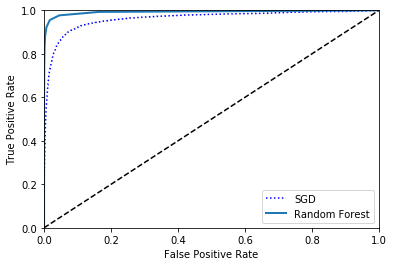

In [65]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")

plt.show()

In [67]:
roc_auc_score(y_train_5, y_scores_forest)

0.9926072105881163

Preguiça de traduzir mas é isso:

Hopefully you now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/
recall tradeoff that fits your needs, and compare various models using ROC curves
and ROC AUC scores.

## Multiclass Classification

Vimos classificadores binários que distinguem entre duas classes. Agora veremos classificadores multiclasses ou multinomiais que distinguem entre 2 ou mais classes.

Alguns algorítmos conseguem lidar com muitas classes diretamente (como florestas aleatorias e naive Bayes). Outros (como SVM e lineares) são estritamente binários. De qualquer forma, é possível montar um classificador multiclasse a partir de vários classificadores binários!

### Fazendo a partir de binários

#### OvO

one-versus-one é um classificador pra cada par de classes, ou seja:
$$n_{classifiers} = {n_{classes}\choose 2}$$


#### OvA

one-versus-all é um classificador para cada classe

$$n_{classifiers} = n_{classes}$$


Sklearn detecta quando vc tenta fazer um classificador multiclasse com um modelo binário e ele mesmo implementa OvA. Exceto pra SVM que ele roda OvO

In [69]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [71]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -6586.26509167, -16035.51864084,  -9722.54554815,
         -1948.26325042, -13493.93327599,   1609.35877433,
        -19762.07284916, -15479.5960437 ,  -7332.44412716,
        -24353.8235989 ]])

In [100]:
np.argmax(some_digit_scores)

5

In [74]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [101]:
sgd_clf.classes_[5]

5.0

Dá pra forçar o uso de um dos tipos de combinação

In [77]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

Floresta não tem caô

In [103]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [104]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.8, 0.1, 0. , 0.1, 0. ]])

Fazer uma validação simples da floresta

In [82]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.93926215, 0.94069703, 0.94219133])

## Análise de erros

demora muito a rodar

In [105]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()

Famosíssima matriz de confusão! Agora para 10 classes!

In [107]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5798,    2,   22,    6,   15,   20,   27,    2,   30,    1],
       [   1, 6619,   39,   16,   14,   10,    6,   16,   15,    6],
       [  50,   19, 5633,   49,   37,   13,   25,   47,   69,   16],
       [  23,   13,  131, 5634,   14,  134,   10,   60,   78,   34],
       [  22,   14,   33,   11, 5550,    7,   34,   18,   22,  131],
       [  52,   12,   34,  178,   23, 4977,   57,    6,   52,   30],
       [  39,   18,   26,    2,   39,   72, 5702,    1,   19,    0],
       [  10,   26,   89,   22,   66,    4,    0, 5948,   19,   81],
       [  41,   58,   94,  144,   49,  104,   45,   22, 5206,   88],
       [  32,   13,   22,   83,  181,   55,    6,   97,   53, 5407]])

Vamos tornar mais visual

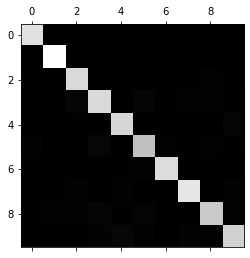

In [108]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Vamos tornar os erros mais visuais!

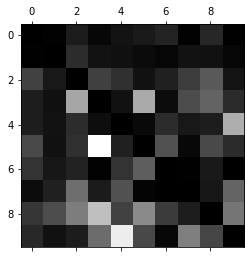

In [109]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

agora sabemos alguns erros comuns do modelo. Como o fato dele confundir o 5 com o 3 e o 9 com 4, principalmente.

Notem que os erros não são necessariamente espelhados, mas parece existir essa relação.

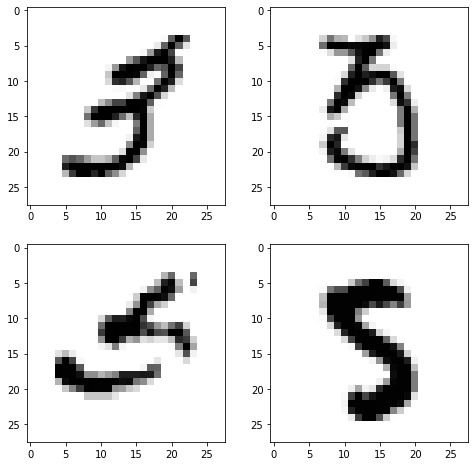

In [123]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(X_aa[2].reshape(28,28), cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.subplot(222)
plt.imshow(X_ab[10].reshape(28,28), cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.subplot(223)
plt.imshow(X_ba[9].reshape(28,28), cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.subplot(224)
plt.imshow(X_bb[1].reshape(28,28), cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.show()

## Multilabel Classification

E se precisarmos dar mais de uma resposta por instância?

vamos de Knn para dar exemplo

In [94]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [95]:
knn_clf.predict([some_digit])

array([[False,  True]])

Aqui fazemos F1 score pra cada label depois é feito a média, dando o mesmo peso para todas as labels.

* average="weighted" é uma opção para deixar o processo mais justo com classes menos presentes

In [96]:
# muito lento
#knn_clf = KNeighborsClassifier()
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
#f1_score(y_train, y_train_knn_pred, average="macro")

## Multioutput Classification

É uma classificação multilabel em que cada label pode ser multiclasse. Ou seja, seu modelo vai ter que cuspir um vetor de labels no qual cada label deve ser escolhida entre várias classes

In [124]:
import numpy.random  as rand

In [133]:
noise1 = rand.randint(0, 140, (len(X_train), 784))
noise2 = rand.randint(0, 140, (len(X_test), 784))
X_train_mod = X_train + noise1
X_test_mod = X_test + noise2
y_train_mod = X_train
y_test_mod = X_test

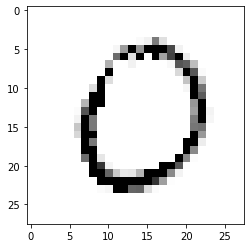

In [134]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])
plt.imshow(clean_digit.reshape((28,28)), cmap = matplotlib.cm.binary, interpolation = 'nearest')

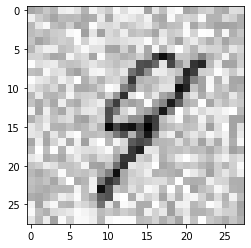

In [135]:
plt.imshow(X_test_mod[9000].reshape((28,28)), cmap = matplotlib.cm.binary, interpolation = 'nearest')

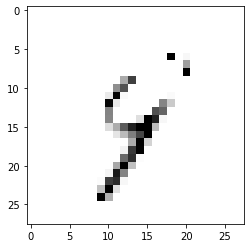

In [136]:
clean_digit = knn_clf.predict([X_test_mod[9000]])
plt.imshow(clean_digit.reshape((28,28)), cmap = matplotlib.cm.binary, interpolation = 'nearest')